# README
### Introduction
- This jupityr notebook applies a series of transformations to the uncleaned data, with the goal of returning cleaned data 

### The only code block sections that likely require user input are the following:
- Source and Destination Locations
    - Simply update source and destination as desired
- Start each depth-resistance curve when arm first contacts the ground
    - remove_data_prior_to_ground(...) arguments: 
        - subrange_max_resistance
            - An empty list is created and appends resistance subranges with each subrange seperated by resistance=0 value, and only if the subrange maximum resistance is above subrange_max_resistance * df['resistance'].max()
        - spacing_between_ranges:
            - Function remove_data_prior_to_ground(...) reverse iterates through the resistance subrange list, choosing the ground starts index when the next subrange is farther then spacing_between_ranges * len(dp['depth'])
- Remove bad samples
    - (optional) Create a list of indexes which correspond to badly sampled depth-resistance curves 

# Remove old data from folders and create data folders to save plots and cleaned data to

In [49]:
import os
import shutil

clean_folder_names = ['data/uncleaned_plots', 'data/cleaned_data', 'data/cleaned_plots']
def remove_old_data_from_folders(clean_folder_names):
    for folder in clean_folder_names:
        if os.path.exists(folder) and os.path.isdir(folder):
            shutil.rmtree(folder)

create_folder_names = ['data', 'data/uncleaned_plots', 'data/cleaned_data', 'data/cleaned_plots']
def create_data_folders(create_folder_names):
    for folder in create_folder_names:
        if not os.path.exists(folder):
            os.makedirs(folder)  # creates all intermediate directories if needed

remove_old_data_from_folders(clean_folder_names)
create_data_folders(create_folder_names)

# Source and Destination Locations

In [50]:
# do you want to save the plots and cleaned data generated in this file to the path destinations below?
# Keep on false when testing, as it runs much faster when not saving figuresS
save_data_bool = False

# the source folder of the uncleaned csv data
uncleaned_data_src = "data/uncleaned_data"

# location for saving cleaned csv files
save_cleaned_csv_dst = "data/cleaned_data/resistance_depth_"

# location for saving uncleaned plots, in folder it'll look like: resistance_depth_1, resistance_depth_2, ...
save_uncleaned_plots_dst = "data/uncleaned_plots/resistance_depth_"

# location for saving cleaned plots
save_cleaned_plots_dst = "data/cleaned_plots/resistance_depth_"

# index of example depth-resistance curve to plot after each data transformation
plot_idx = 15

# Read in white sands csv files and turn them into dataframes

In [51]:
import os
import pandas as pd
import copy

def get_data(data_src_folder_path):
    df_list = []
    for filename in os.listdir(data_src_folder_path):
        df = pd.read_csv(f"{data_src_folder_path}/{filename}")
        df = df[['toeforce_y', 'toe_position_y']] # takes just the two important columns
        df.columns = ["resistance", "depth"] # rename columns
        df_list.append(df)
    return df_list

uncleaned_df_list = get_data(uncleaned_data_src)
df_list = copy.deepcopy(uncleaned_df_list)
print(f"example: {df_list[0]}")


example:        resistance     depth
0       -0.683593 -0.188659
1       -0.683593 -0.188659
2       -0.683593 -0.188659
3       -0.683593 -0.188659
4       -0.683593 -0.188659
...           ...       ...
11599   -1.929471 -0.158198
11600   -1.929471 -0.158198
11601   -1.929471 -0.158198
11602   -1.929471 -0.158198
11603   -1.929471 -0.158198

[11604 rows x 2 columns]


# Initial Data Visualization and Summary

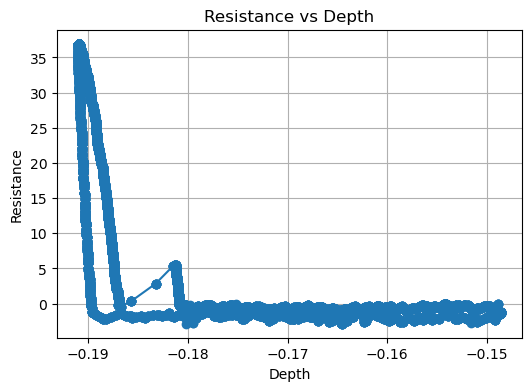

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt

"""This function will be used at the very end of the cleaning process for comparing before and after cleaning of plots"""
def compare_plots_before_and_after_cleaning(uncleaned_df_list, cleaned_df_list, removed_list=[], plot_indicies=[]):
    uncleaned_idx = 0
    cleaned_idx = 0
    for i in range(len(uncleaned_df_list)):
        if i not in removed_list:
            if i in plot_indicies:
                print(f"uncleaned idx: {uncleaned_idx}")
                plt.figure(figsize=(5,3))         # Optional: set figure size
                plt.plot(uncleaned_df_list[uncleaned_idx]['depth'], uncleaned_df_list[uncleaned_idx]['resistance'], marker='o', linestyle='-')
                plt.xlabel('Depth')
                plt.ylabel('Resistance')
                plt.title('Uncleaned: Resistance vs Depth')
                plt.grid(True)                    
                plt.show()

                print(f"cleaned idx: {cleaned_idx}")
                plt.figure(figsize=(5,3))         # Optional: set figure size
                plt.plot(cleaned_df_list[cleaned_idx]['depth'], cleaned_df_list[cleaned_idx]['resistance'], marker='o', linestyle='-')
                plt.xlabel('Depth')
                plt.ylabel('Resistance')
                plt.title('Cleaned: Resistance vs Depth')
                plt.grid(True)                    
                plt.show()
                print("-----------------------------------------------------------")

            uncleaned_idx += 1
            cleaned_idx += 1

        else:
            uncleaned_idx += 1



# Assume you have a DataFrame df with columns 'depth' and 'resistance'
def visualize_data(df_list, generate_plot_idx=-1, save_plots_bool=False, save_plots_dst="", generate_box_plots=False, 
                   generate_histograms=False):

    if generate_plot_idx != -1:
        plt.figure(figsize=(6,4))         # Optional: set figure size
        plt.plot(df_list[generate_plot_idx]['depth'], df_list[generate_plot_idx]['resistance'], marker='o', linestyle='-')
        plt.xlabel('Depth')
        plt.ylabel('Resistance')
        plt.title('Resistance vs Depth')
        plt.grid(True)                    
        plt.show()
    
    if save_plots_bool and len(save_plots_dst) > 0:
        combined_columnes = pd.concat(df_list, axis=0)
        for i, df in enumerate(df_list):
            plt.figure(figsize=(8,6))         # Optional: set figure size
            plt.plot(df['depth'], df['resistance'], marker='o', linestyle='-')
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            if "uncleaned" not in save_plots_dst:
                plt.xlim([0, combined_columnes['depth'].max()])
                plt.ylim([0, combined_columnes['resistance'].max()])
            plt.title('Resistance vs Depth')
            plt.grid(True)
            plt.savefig(f"{save_plots_dst}{i}")
            plt.close()

    df_combined_row_wise = pd.concat(df_list, axis=0)
    if generate_box_plots:
        plt.figure(figsize=(3,2))         # Optional: set figure size
        # ---- resistance ----
        sns.boxplot(x=df_combined_row_wise['resistance'])
        plt.show()
        resistance_series = df_combined_row_wise['resistance']
        # ---- depth ----
        plt.figure(figsize=(3,2))         # Optional: set figure size
        sns.boxplot(x=df_combined_row_wise['depth'])
        plt.show()
    if generate_histograms:
        plt.hist(df_combined_row_wise["resistance"], bins=30, density=True)
        plt.title("Resistance Histogram")
        plt.show()

        plt.hist(df_combined_row_wise["depth"], bins=30, density=True)
        plt.title("Depth Histogram")
        plt.show()


visualize_data(df_list, generate_plot_idx=plot_idx, save_plots_bool=save_data_bool, 
                save_plots_dst=save_uncleaned_plots_dst)

# Flip curve over y-axis

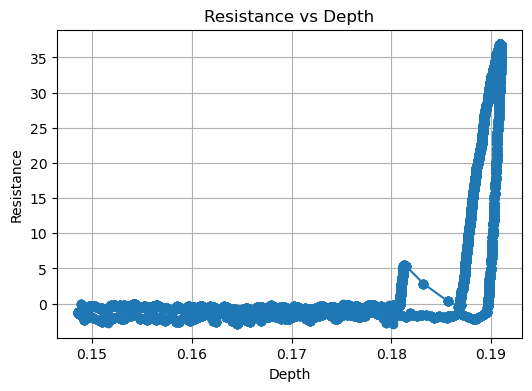

In [53]:
def flip_over_y_axis(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df['depth'] = -copy_df['depth']
        # if data_file == "mh23":
        #     copy_df['resistance'] = -copy_df['resistance']
        cleaned_df_list.append(copy_df)
    return cleaned_df_list

df_list = flip_over_y_axis(df_list)
visualize_data(df_list, generate_plot_idx=plot_idx)

# Remove all data points after the max depth

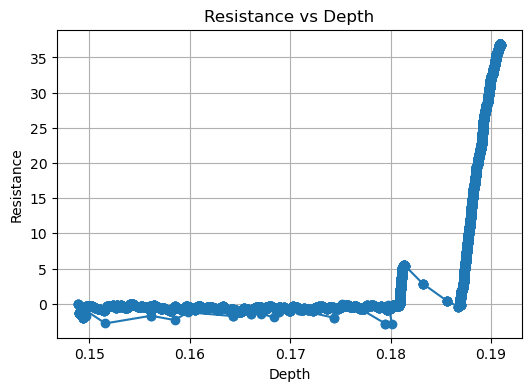

In [54]:
def remove_points_after_max_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        end_idx = df[df["depth"] == df["depth"].max()].index[0]
        cleaned_df = df.iloc[:end_idx+1]
        cleaned_list.append(cleaned_df)
    return cleaned_list

df_list = remove_points_after_max_depth(df_list)
visualize_data(df_list, generate_plot_idx=plot_idx)

# Remove all data points before min depth

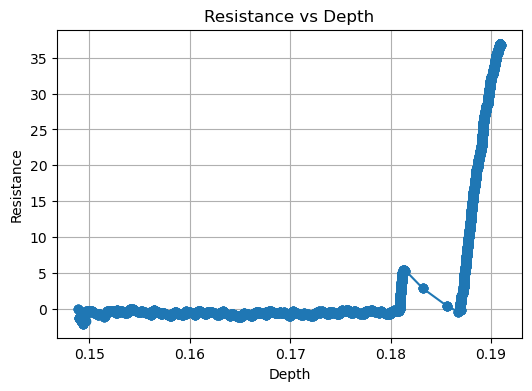

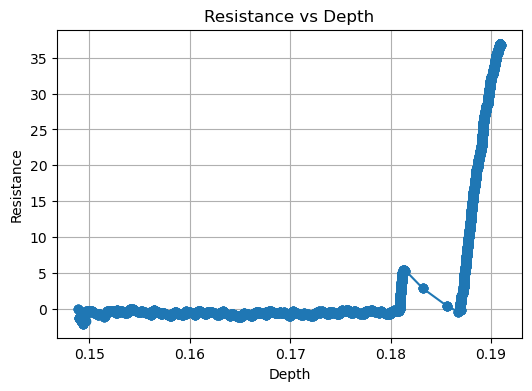

In [55]:
def remove_points_before_min_depth(df_list):
    cleaned_list = []
    for i, df in enumerate(df_list):
        min_idx = df[df["depth"] == df["depth"].min()].index[0]
        cleaned_df = df.iloc[min_idx:]
        cleaned_list.append(cleaned_df)
    return cleaned_list

df_list = remove_points_before_min_depth(df_list)
visualize_data(df_list, generate_plot_idx=plot_idx)
visualize_data(df_list, generate_plot_idx=plot_idx)

# Make resistance = 0 for all resistance values < 0

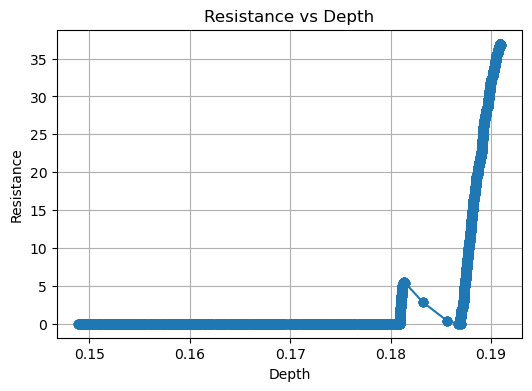

In [56]:
def make_resistance_min_equal_zero(df_list):
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        copy_df["resistance"] = copy_df["resistance"].clip(lower=0)
        cleaned_df_list.append(copy_df)
    return cleaned_df_list
df_list = make_resistance_min_equal_zero(df_list)
visualize_data(df_list, generate_plot_idx=plot_idx)

# Make sure depth values are only increasing

Number of dataframes with non-ascending values: 80


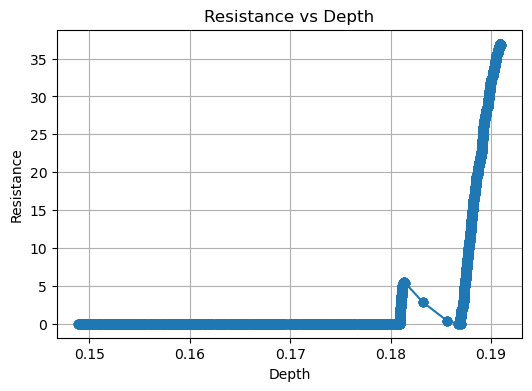

Number of dataframes with non-ascending values: 0


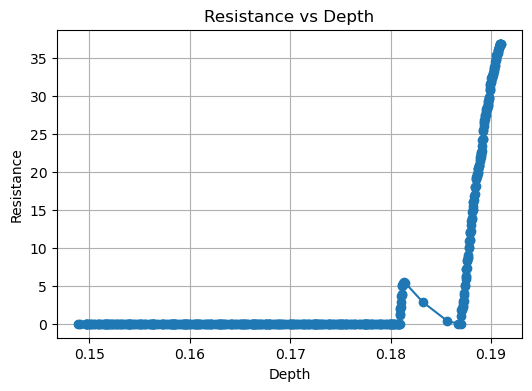

In [57]:
def num_dataframes_with_ascending_depth(df_list):
    count = 0
    for df in df_list:
        if not (df['depth'].is_monotonic_increasing and df['depth'].is_unique): 
            count += 1
    return count

def only_increasing_depth(df_list):
    cleaned_df_list = []
    for df in df_list:
        mask = [1]  # keep the first row
        current_max_depth = df['depth'].iloc[0]
        for i in range(1, len(df)):
            if df['depth'].iloc[i] > current_max_depth:
                current_max_depth = df['depth'].iloc[i]
                mask.append(1)
            else:
                mask.append(0)
        mask_series = pd.Series(mask, index=df.index)
        cleaned_df_list.append(df.loc[mask_series.astype(bool)])

    return cleaned_df_list

# show before and after
print(f"Number of dataframes with non-ascending values: {num_dataframes_with_ascending_depth(df_list)}")
visualize_data(df_list, generate_plot_idx=plot_idx)
df_list = only_increasing_depth(df_list)
print(f"Number of dataframes with non-ascending values: {num_dataframes_with_ascending_depth(df_list)}")
visualize_data(df_list, generate_plot_idx=plot_idx)

# Start each depth-resistance curve when arm first contacts the ground
- User doesn't need to interact with this code block, as these are supporting functions for a higher level function remove_data_prior_to_ground(...)
- remove_data_prior_to_ground(...) is called and managed by user in code block after the one below

In [58]:
import pandas as pd

def find_positive_subranges_of_resistance(df):
    """
    - args: 
        - dp: depth-resistance dataframe
    - returns:
        - parallel arrays: df['resistance'] subranges seperated by 0-values & the maximum resistance within each subrange
    - ex
        - if df["resistance"] = [0,1,2,1,0,1,2,3,4,5], this function would output ( [(0,3), (4,9)], [2, 5] ) 
        - first sub range is [0,1,2,1] with a max resistance of 2
        - second sub range is [0,1,2,3,4,5] with a max resistance of 5
    """
    ranges_above_zero_list = []
    range_max_height_list = []

    in_range = False
    range_start_idx = None
    range_max_resistance = 0

    for i, res in enumerate(df["resistance"]):
        if res > 0:
            if not in_range:
                # starting a new range
                in_range = True
                if i > 0: range_start_idx = i - 1
                else: range_start_idx = 0
                range_max_resistance = res
            else:
                range_max_resistance = max(range_max_resistance, res)
        elif in_range:
            # end of a positive range
            ranges_above_zero_list.append((range_start_idx, i - 1))
            range_max_height_list.append(range_max_resistance)
            in_range = False

    # handle if last element was part of a range
    if in_range:
        ranges_above_zero_list.append((range_start_idx, len(df["resistance"]) - 1))
        range_max_height_list.append(range_max_resistance)

    return ranges_above_zero_list, range_max_height_list

def filter_subranges(subrange_list, subrange_max_resistance_list, subrange_max_resistance):
    max_resistance_overall = max(subrange_max_resistance_list)
    filtered_subranges = []
    for i, pos_range in enumerate(subrange_list):
        if subrange_max_resistance_list[i] > max_resistance_overall * subrange_max_resistance:
             filtered_subranges.append(pos_range)
    return filtered_subranges

def get_ground_start_idx(df, subrange_max_resistance, spacing_between_ranges):
    """
    - args
        - dp: depth-resistance dataframe
        - subrange_max_resistance (user defined threshold used for selecting resistance subranges above this value)
        - spacing_between_ranges (user defined threshold for droping subranges with a max resistance)
    - returns
        - index where the robotic arm contacts the ground - i.e where the curve should start
    """
    subrange_list, subrange_max_resistance_list = find_positive_subranges_of_resistance(df)

    if len(subrange_list) < 1: return 0
    
    # removes subranes below subrange_max_resistance threshold
    filtered_subranges = filter_subranges(subrange_list, subrange_max_resistance_list, subrange_max_resistance)

    ground_start_idx = filtered_subranges[-1][0] # init ground_start_idx with start of largest curve (last subrange in range_list)
    if len(filtered_subranges) < 2: return ground_start_idx

    # reverse iterate over the filtered subranges and stop when the distance from subrange i to j is too high
    for i in range(len(filtered_subranges)-2, -1, -1): 
        subrange_i_start_idx = df["depth"].iloc[filtered_subranges[i][1]]
        subrange_j_end_idx = df["depth"].iloc[filtered_subranges[i+1][0]]
        if subrange_j_end_idx - subrange_i_start_idx > spacing_between_ranges * len(df["depth"]):
            ground_start_idx = filtered_subranges[i+1][0]
            break # found our final ground_start_idx
        else:
            ground_start_idx = filtered_subranges[i][0]
    return ground_start_idx

def remove_data_prior_to_ground(df_list, subrange_max_resistance, spacing_between_ranges):
    """
    - args
        - dp: depth-resistance dataframe
        - range_max_res (user defined threshold used for dropping resistance subranges with a max resistance below this value)
        - spacing_between_ranges (user defined threshold for dropping subranges that have a distance from one another higher then desired)
    - returns
        - dataframe with all data prior to first contact with ground removed and adjusted to start at 0
    """
    cleaned_df_list = []
    for df in df_list:
        copy_df = df.copy()
        start_idx = get_ground_start_idx(copy_df, subrange_max_resistance, spacing_between_ranges)
        copy_df = copy_df.iloc[start_idx:]
        # copy_df = start_curve_at_ground(copy_df, subrange_max_resistance, spacing_between_ranges)
        copy_df["depth"] = copy_df["depth"] - copy_df['depth'].iloc[0]
        cleaned_df_list.append(copy_df)
    return cleaned_df_list



### Quick Overview
- def remove_data_prior_to_ground(df_list, subrange_max_resistance, spacing_between_subranges)
    - args
        - dp: depth-resistance dataframe
        - subrange_max_resistance
            - user defined threshold used for dropping resistance subranges with a max resistance below this value
            - higher (lower) value means only subranges with high (lower) maximum threshold are considered as the start of the curve
        - spacing_between_ranges 
            - user defined threshold for dropping subranges that have a distance from one another higher then desired
            - higher (lower) value means allowed distances between subranges can be higher (lower)
    - returns
        - dataframe with all data prior to first contact with ground removed and adjusted to start at 0

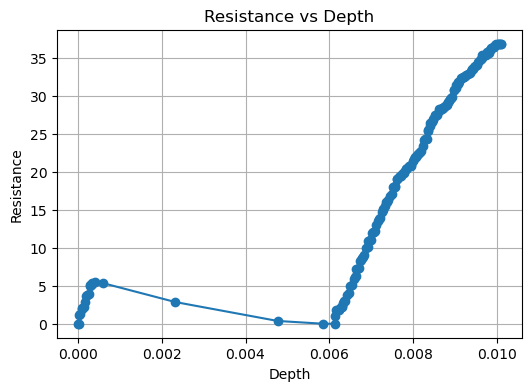

In [59]:
# df_list = remove_data_prior_to_ground(df_list, subrange_max_resistance=0.1, spacing_between_ranges=0.00001)
df_list = remove_data_prior_to_ground(df_list, subrange_max_resistance=0.1, spacing_between_ranges=0.0001)
visualize_data(df_list, generate_plot_idx=plot_idx)

# Interpolation to uniformly resample points from curve

Before interpolation


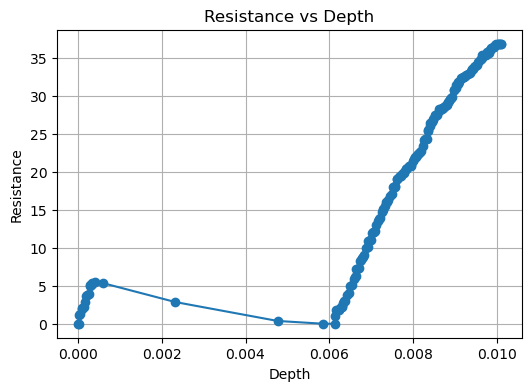

After interpolation


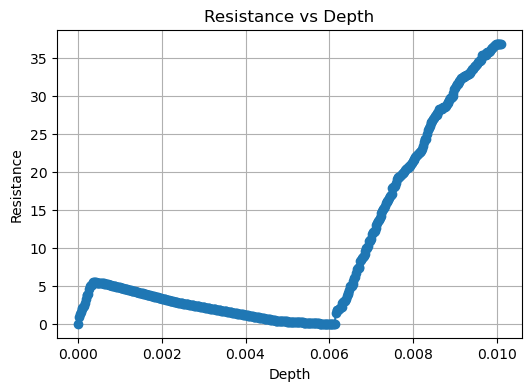

In [60]:
import numpy as np
def interpolate(df_list, num_points):
    interp_df_list = []
    for df in df_list:
        x_intervals = np.linspace(0, df['depth'].max(), num_points, endpoint=True) # 100 points between 0 and trunc_level
        y_new = np.interp(x_intervals, df["depth"], df["resistance"])
        new_df = pd.DataFrame({'depth': x_intervals, 'resistance': y_new})
        interp_df_list.append(new_df)
    return interp_df_list

print("Before interpolation")
visualize_data(df_list, generate_plot_idx=plot_idx)
df_list = interpolate(df_list, 500)
print("After interpolation")
visualize_data(df_list, generate_plot_idx=plot_idx)

# Remove bad samples

In [61]:
# remove_list = {
#     "ws23": [66], # 66 bad sample,
#     "mh23": [0, 14, 19, 23, 26, 35, 36, 37, 38, 39, 45, 46, 47, 49, 50, 53, 58, 65, 74, 79]
# }

# list of depth-resistance plots indices to remove from cleaned data set (bad samples, ect...)
remove_list = [66]

def remove_bad_samples(df_list, remove_list):
    cleaned_samples_list = []
    for i, df in enumerate(df_list):
        if i not in remove_list:
            cleaned_samples_list.append(df)
    return cleaned_samples_list

print(f"df_list length: {len(df_list)}")
df_list = remove_bad_samples(df_list, remove_list)
print("bad samples removed")
print(f"df_list length: {len(df_list)}")

df_list length: 81
bad samples removed
df_list length: 80


# Save photos of all cleaned curves

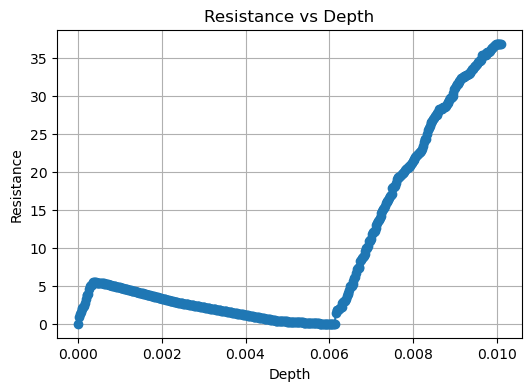

In [62]:
visualize_data(df_list, generate_plot_idx=plot_idx, save_plots_bool=save_data_bool, 
                save_plots_dst=save_cleaned_plots_dst)

# Save the cleaned csv files

In [63]:
def save_data_csv(final_df_list, save_to_folder_path, save: bool):
    if save:
        for i in range(len(final_df_list)):
            final_df_list[i].to_csv(f"{save_to_folder_path}{i}.csv")

save_data_csv(df_list, save_to_folder_path=save_cleaned_csv_dst, save=save_data_bool)

# Print out before and after cleaning of plots

uncleaned idx: 6


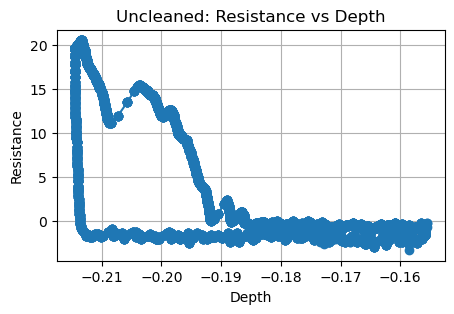

cleaned idx: 6


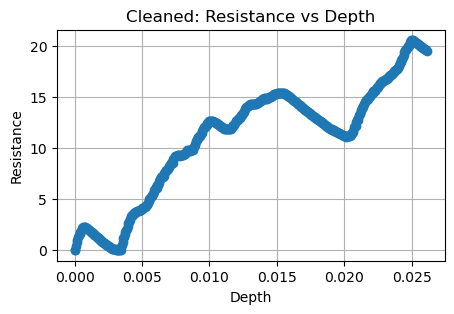

-----------------------------------------------------------
uncleaned idx: 7


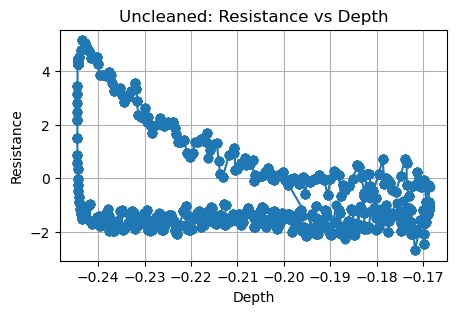

cleaned idx: 7


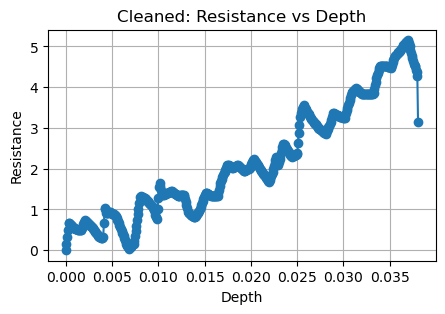

-----------------------------------------------------------
uncleaned idx: 13


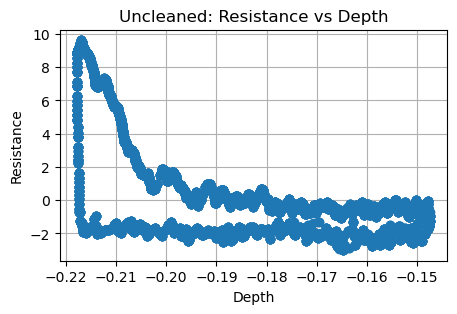

cleaned idx: 13


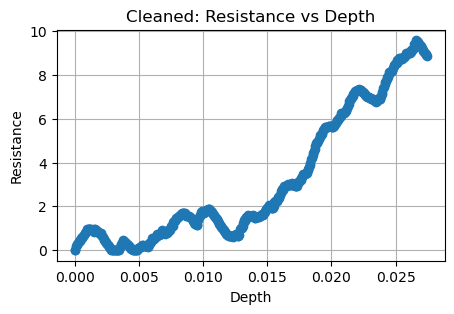

-----------------------------------------------------------
uncleaned idx: 15


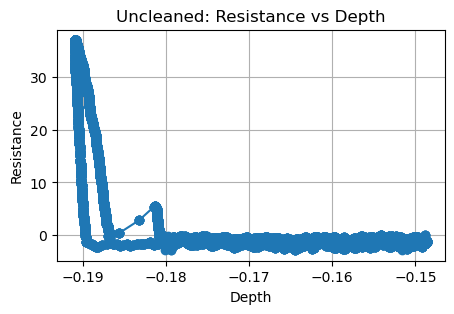

cleaned idx: 15


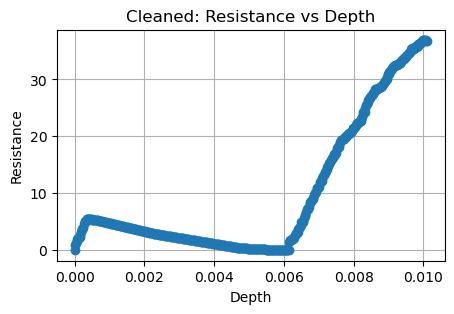

-----------------------------------------------------------
uncleaned idx: 23


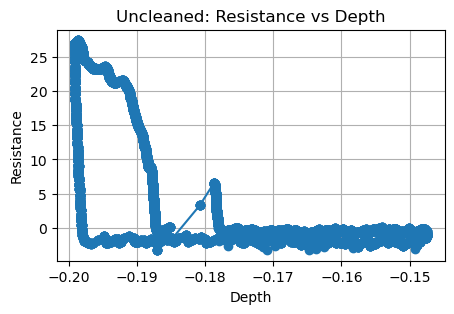

cleaned idx: 23


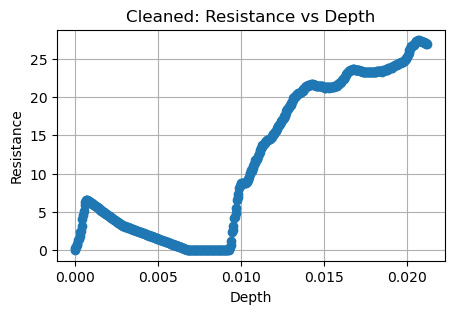

-----------------------------------------------------------
uncleaned idx: 31


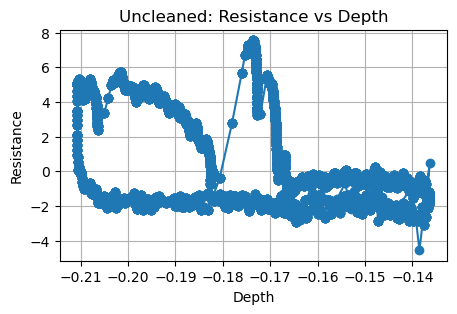

cleaned idx: 31


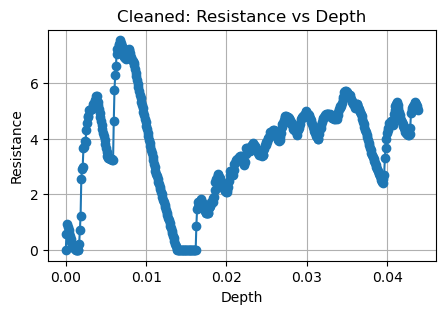

-----------------------------------------------------------
uncleaned idx: 32


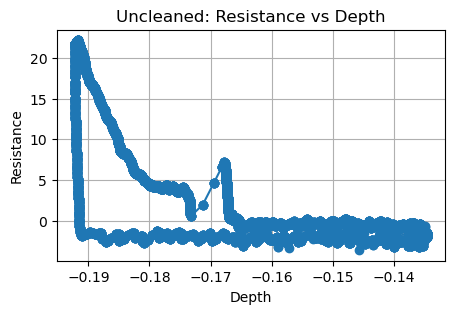

cleaned idx: 32


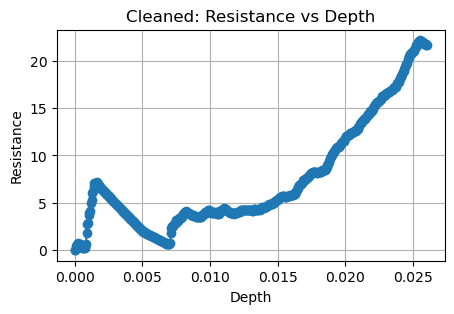

-----------------------------------------------------------
uncleaned idx: 39


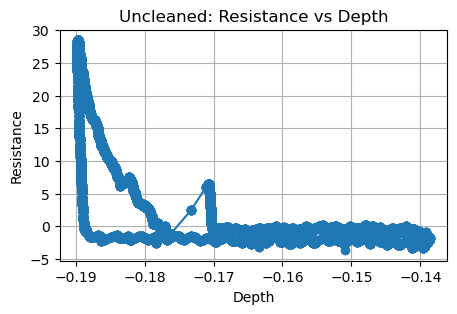

cleaned idx: 39


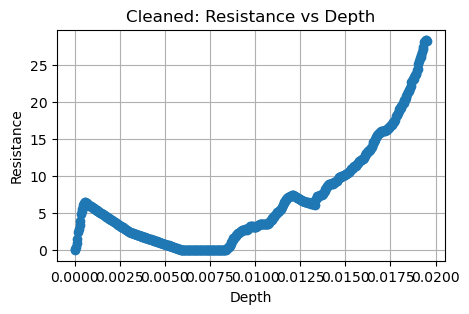

-----------------------------------------------------------
uncleaned idx: 47


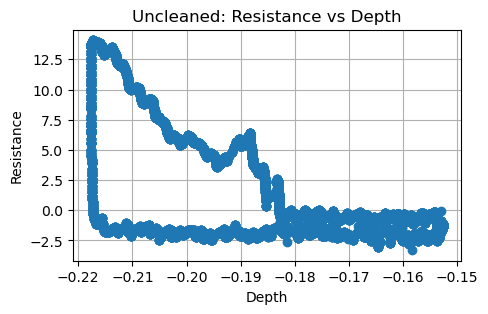

cleaned idx: 47


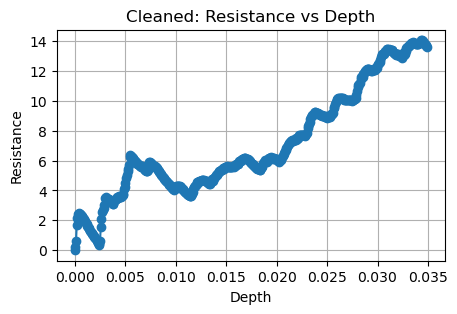

-----------------------------------------------------------
uncleaned idx: 51


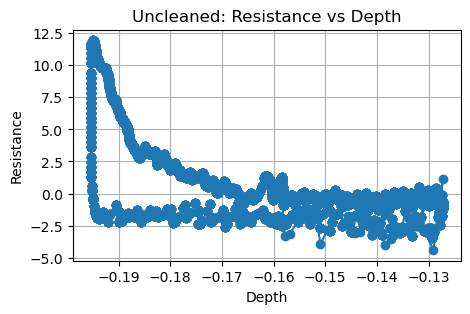

cleaned idx: 51


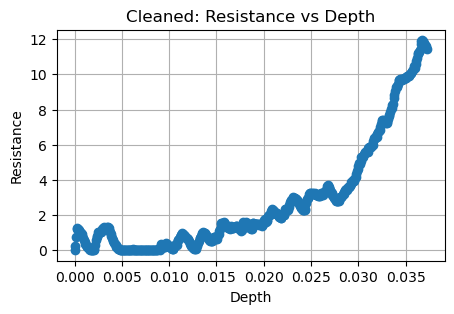

-----------------------------------------------------------
uncleaned idx: 62


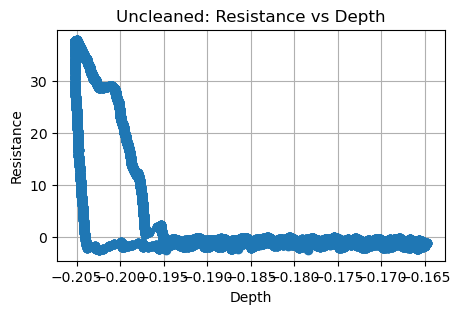

cleaned idx: 62


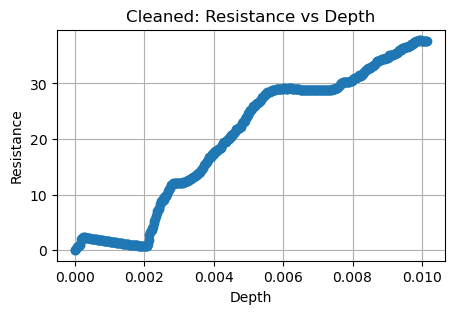

-----------------------------------------------------------
uncleaned idx: 68


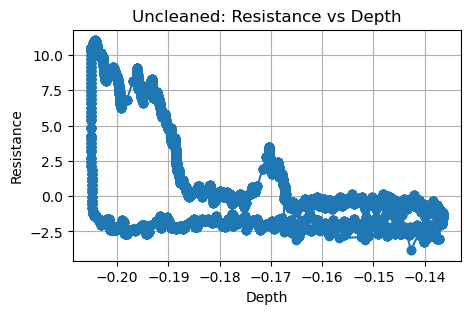

cleaned idx: 67


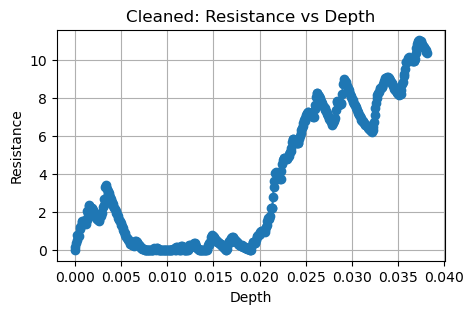

-----------------------------------------------------------
uncleaned idx: 73


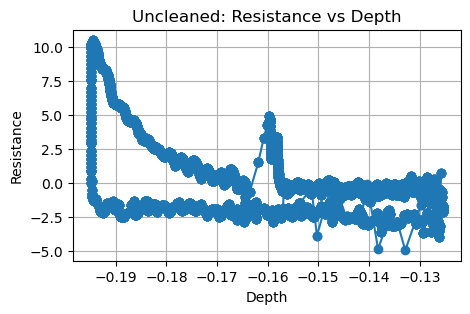

cleaned idx: 72


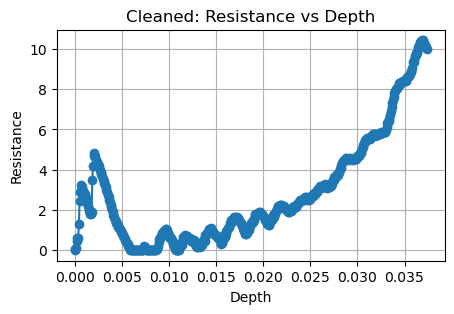

-----------------------------------------------------------


In [ ]:
compare_plots_before_and_after_cleaning(uncleaned_df_list, cleaned_df_list=df_list, 
        removed_list=remove_list, plot_indicies=[6,7,13,15,23,31,32,39,47,51,62,68,73])